In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import asapy
import numpy as np
from time import time

# Cenário: Demonstração de Navegação com Aeronave de Caça

### Descrição Geral:
Este cenário descreve um voo de navegação realizado por uma aeronave de caça, enfocando a execução de manobras em diferentes altitudes e velocidades. A navegação abrange uma variação de altitude entre Flight Level (FL) 100 e FL 350, bem como uma variação de velocidade entre 350 knots e 550 knots. Durante este voo, no terceiro ponto da rota, a aeronave realizará uma manobra de espera em torno de um ponto específico (**Hold**) durante 10 minutos, integrando-a ao padrão de voo.

<img src='./data/nav_demo.gif' width='500' height='500'>

#### Carregando Dados das Simulações

Nesta célula, estamos carregando dados de diferentes simulações a partir de arquivos CSV. Para cada cenário, existem dois tipos de arquivos:

1. Arquivos `*_aliases.csv`: Estes contêm as entradas (ou parâmetros) para cada simulação.

2. Arquivos `*_output.csv`: Estes contêm os resultados das simulações. 

Os dados são lidos e carregados em DataFrames do pandas para análise e processamento subsequentes.


In [2]:
x = pd.read_csv('./data/nav_demo_aliases.csv')
y = pd.read_csv('./data/nav_demo_output.csv')

In [3]:
preprocessing  = asapy.Preprocessing()

x = preprocessing.aliases(x)
y = preprocessing.team_metrics(y)

In [4]:
df_nav = pd.merge(x, y[['fuel_consumed']], left_index=True, right_index=True)

In [5]:
sample_nav = df_nav.sample(10)
df_nav = df_nav.loc[~df_nav.index.isin(sample_nav.index)]

In [6]:
df_nav.head(5)

,speed,altitude,fuel_consumed
experiment,,,
0,485.10,13339.30,1460.593196
1,518.46,34516.34,883.070714
2,501.61,23487.75,1063.105283
3,525.65,16748.43,1400.689116
4,438.32,21489.87,1051.047824


In [7]:
df_nav["speed_without_mean"] = df_nav["speed"] - df_nav["speed"].mean()

In [8]:
df_nav["altitude_without_mean"] = df_nav["altitude"] - df_nav["altitude"].mean()

In [9]:
df_nav["speed_without_mean_div_std"] = (df_nav["speed"] - df_nav["speed"].mean()) / df_nav["speed"].std()

In [10]:
df_nav["altitude_without_mean_div_std"] = (df_nav["altitude"] - df_nav["altitude"].mean()) / df_nav["altitude"].std()

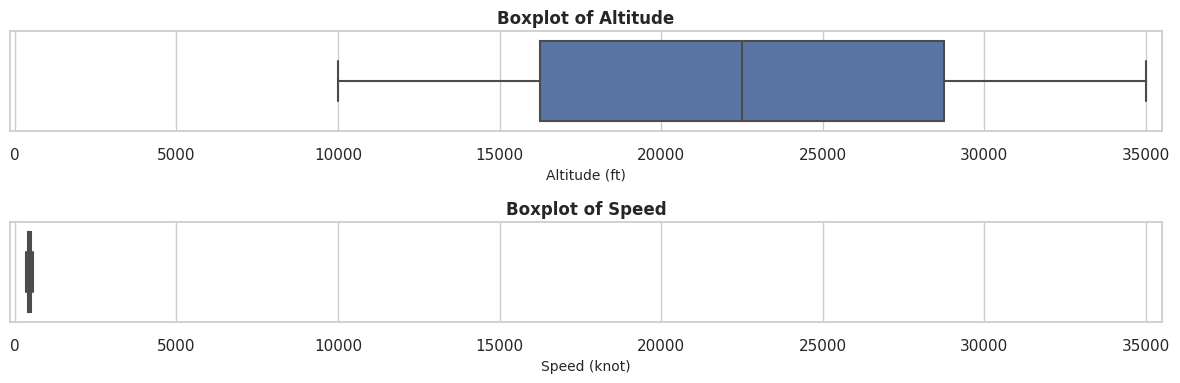

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

# Definindo o estilo do gráfico
sns.set(style="whitegrid")

# Criando uma nova figura para os boxplots
plt.figure(figsize=(12, 4))

min_value = min(df_nav["speed"].min() - 500, df_nav["altitude"].min() - 500)
max_value = max(df_nav["speed"].max() + 500, df_nav["altitude"].max() + 500)

# Criando o boxplot para altitude_without_mean_div_std
plt.subplot(2, 1, 1)  # 1 linha, 2 colunas, posição 2
sns.boxplot(x=df_nav["altitude"])
plt.title('Boxplot of Altitude', fontsize=12, fontweight='bold')
plt.xlim(min_value, max_value)  # Definindo os mesmos limites para o eixo x
plt.xlabel("Altitude (ft)", fontsize=10)

# Criando o boxplot para speed_without_mean_div_std
plt.subplot(2, 1, 2)  # 1 linha, 2 colunas, posição 1
sns.boxplot(x=df_nav["speed"])
plt.title('Boxplot of Speed', fontsize=12, fontweight='bold')
plt.xlim(min_value, max_value)  # Definindo os mesmos limites para o eixo x
plt.xlabel("Speed (knot)", fontsize=10)

# Mostrando o gráfico
plt.tight_layout()

plt.savefig('boxplot1.png')
plt.show()

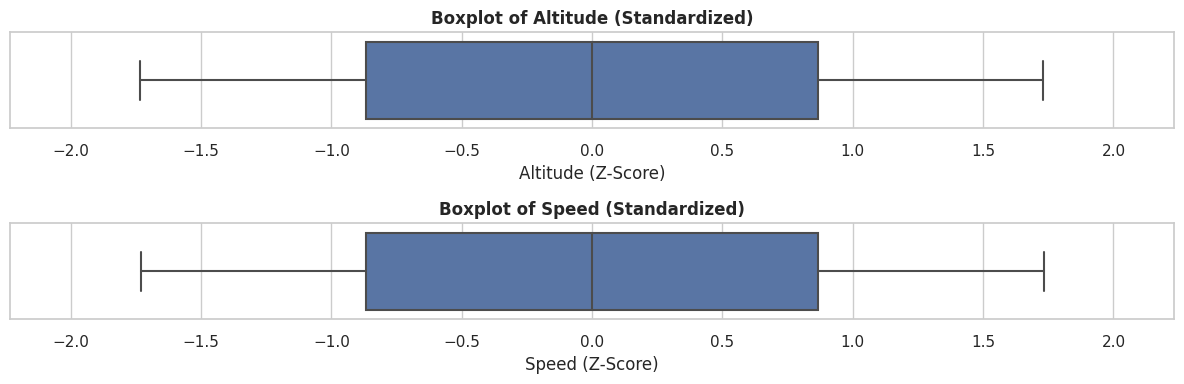

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

# Definindo o estilo do gráfico
# sns.set(style="whitegrid")

# Criando uma nova figura para os boxplots
plt.figure(figsize=(12, 4))

min_value = min(df_nav["speed_without_mean_div_std"].min() - 0.5, df_nav["altitude_without_mean_div_std"].min() - 0.5)
max_value = max(df_nav["speed_without_mean_div_std"].max() + 0.5, df_nav["altitude_without_mean_div_std"].max() + 0.5)

# Criando o boxplot para altitude_without_mean_div_std
plt.subplot(2, 1, 1)  # 1 linha, 2 colunas, posição 2
sns.boxplot(x=df_nav["altitude_without_mean_div_std"])
plt.title('Boxplot of Altitude (Standardized)', fontsize=12, fontweight='bold')
plt.xlim(min_value, max_value)  # Definindo os mesmos limites para o eixo x
plt.xlabel("Altitude (Z-Score)", fontsize=12)

# Criando o boxplot para speed_without_mean_div_std
plt.subplot(2, 1, 2)  # 1 linha, 2 colunas, posição 1
sns.boxplot(x=df_nav["speed_without_mean_div_std"])
plt.title('Boxplot of Speed (Standardized)', fontsize=12, fontweight='bold')
plt.xlim(min_value, max_value)  # Definindo os mesmos limites para o eixo x
plt.xlabel("Speed (Z-Score)", fontsize=12)

# Mostrando o gráfico
plt.tight_layout()
plt.savefig('boxplot2.png')
plt.show()

## EXPERIMENTO 1: Previsão do Consumo de Combustível na rota específica

#### Rede Neural

In [ ]:
start_time_1 = time()

In [ ]:
nn_nav = asapy.NeuralNetwork(target="fuel_consumed", name='demo_nn_nav', seed=25)

In [ ]:
nn_nav.build(
    df_nav,
    task="regression",
    max_cat_nunique = 10,
    split_size = (0.7, 0.15, 0.15),
    info=True,
    patience_early_stopping = 20,
    patience_reduceLR = 4,
    metrics=['rmse']
)

In [ ]:
nn_nav.hyperparameter_optimization(
    n_trials=18,
    num_folds=4,
    info=True,
    search_space_dropout = [0.0, 0.5],
    search_space_layers = [2, 3, 4],
    search_space_batch_size = [32, 64, 128],
    search_space_optimizer = ['Adam']
)

In [ ]:
nn_nav.fit(return_history=False, graph=True, graph_save_extension='eps', verbose=0)

In [ ]:
end_time_1 = time()

In [ ]:
start_time_2 = time()

In [ ]:
pred_nn_nav = nn_nav.predict(sample_nav, verbose=0)

In [ ]:
pred_nn_nav

In [ ]:
end_time_2 = time()

In [ ]:
print(f"Tempo de Treinamento: {end_time_1 - start_time_1}")

In [ ]:
print(f"Tempo de Inferência: {end_time_2 - start_time_2}")

#### XG Boost

In [ ]:
start_time_3 = time()

In [ ]:
xgb_nav = asapy.XgBoost(target="fuel_consumed", name='demo_xgb_nav', seed=25)

In [ ]:
xgb_nav.build(
    df_nav,
    task="regression",
    num_folds=5,
    max_cat_nunique = 10,
    split_size = (0.7, 0.15, 0.15),
    info=True,
    patience_early_stopping = 20,
    metrics=['mse']
)

In [ ]:
xgb_nav.hyperparameter_optimization(
    n_trials=10,
    num_folds = 5, 
    info=True,
    search_space_tree_method = ['auto'],
    search_space_booster = ['gbtree', 'gblinear', 'dart'],
    search_space_learning_rate = [0.3],
    search_space_min_split_loss = [0],
    search_space_max_depth = [6],
    search_space_min_child_weight = [1],
    search_space_max_delta_step = [0],
    search_space_subsample = [1],
    search_space_sampling_method = ['uniform'],
    search_space_colsample_bytree = [1],
    search_space_colsample_bylevel = [1],
    search_space_colsample_bynode = [1],
    search_space_reg_lambda = [1],
    search_space_reg_alpha = [0],
    search_space_scale_pos_weight = [1],
    search_space_grow_policy = ['depthwise'],
    search_space_max_leaves = [0],
    search_space_max_bin = [256],
    search_space_num_parallel_tree = [1]
)

In [ ]:
history_xgb_nav = xgb_nav.fit(return_history=True, graph=True, graph_save_extension='png', verbose=0)

In [ ]:
end_time_3 = time()

In [ ]:
start_time_4 = time()

In [ ]:
pred_xgb_nav = xgb_nav.predict(sample_nav)

In [ ]:
pred_xgb_nav

In [ ]:
end_time_4 = time()

In [ ]:
print(f"Tempo de Treinamento: {end_time_3 - start_time_3}")

In [ ]:
print(f"Tempo de Inferência: {end_time_4 - start_time_4}")

## EXPERIMENTO 2: Segmentação de classe de Combustível na rota específica

#### KMeans

In [ ]:
start_time_5 = time()

In [ ]:
kmeans_nav = asapy.KMeans(name='demo_kmeans_nav', seed=25)

In [ ]:
kmeans_nav.build(df_nav, info=True)

In [ ]:
kmeans_nav.hyperparameter_optimization(
    n_trials=10,
    info=True,
    search_space_n_clusters=[4],
    search_space_init  = ['k-means++'],
    search_space_n_init = ['auto'],
    search_space_tol = [1e-5, 1e-4, 1e-3],
    search_space_algorithm = ['lloyd', 'elkan']
)

In [ ]:
clusters = kmeans_nav.fit(return_cluster=True)

In [ ]:
kmeans_nav.predict(projection='2d', graph_save_extension='png')

In [ ]:
kmeans_nav.predict(projection='3d', graph_save_extension='png')

In [ ]:
end_time_5 = time()

In [ ]:
print(f"Tempo de Treinamento: {end_time_5 - start_time_5}")

## EXPERIMENTO 3: Previsão da classe de Consumo de Combustível na rota específica

#### Data leak intencional, com o intuito de criar um Case de classificação. Asuma que a nfomação do cluster seja obtida de observação factual

In [ ]:
df_nav_class = df_nav.copy()
df_nav_class['Cluster'] = clusters

In [ ]:
# plt.style.use('seaborn-darkgrid')  # Usa um estilo de fundo do Seaborn
# plt.figure(figsize=(10, 6))  # Tamanho do gráfico

class_counts = df_nav_class['Cluster'].value_counts().sort_index()

bars = plt.bar(class_counts.index, class_counts.values, color='skyblue', edgecolor='black')

plt.title('Balanceamento das Classes', fontsize=16, fontweight='bold')
plt.xlabel('Classes', fontsize=14)
plt.ylabel('Número de Instâncias', fontsize=14)

plt.xticks(class_counts.index, fontsize=12)
plt.yticks(fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.7)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, int(yval), ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
# !pip install imblearn

In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter

sm = SMOTE(random_state=42)
X = df_nav_class.drop('Cluster', axis=1)
y = df_nav_class['Cluster']

X_res, y_res = sm.fit_resample(X, y)

# Se precisar, converta de volta para DataFrame pandas
df_nav_class = pd.DataFrame(X_res, columns=X.columns)
df_nav_class['Cluster'] = y_res

In [ ]:
# plt.style.use('seaborn-darkgrid')  # Usa um estilo de fundo do Seaborn
# plt.figure(figsize=(10, 6))  # Tamanho do gráfico

class_counts = df_nav_class['Cluster'].value_counts().sort_index()

bars = plt.bar(class_counts.index, class_counts.values, color='skyblue', edgecolor='black')

plt.title('Balanceamento das Classes', fontsize=16, fontweight='bold')
plt.xlabel('Classes', fontsize=14)
plt.ylabel('Número de Instâncias', fontsize=14)

plt.xticks(class_counts.index, fontsize=12)
plt.yticks(fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.7)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, int(yval), ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
sample_nav_class = df_nav_class.sample(10)
df_nav_class = df_nav_class.loc[~df_nav_class.index.isin(sample_nav_class.index)]

#### Rede Neural

In [ ]:
start_time_6 = time()

In [ ]:
nn_nav_class = asapy.NeuralNetwork(target="Cluster", name='demo_nn_nav_class', seed=25)

In [ ]:
nn_nav_class.build(
    df_nav_class,
    task='classification',
    max_cat_nunique = 10,
    split_size = (0.7, 0.15, 0.15),
    info=True,
    patience_early_stopping = 20,
    patience_reduceLR = 4,
    metrics=['auc', 'precision', 'recall', 'accuracy'] 
)

In [ ]:
nn_nav_class.hyperparameter_optimization(
    n_trials=10,
    num_folds=5,
    info=True,
    search_space_dropout = [0.0, 0.5],
    search_space_layers = [2, 3, 4],
    search_space_batch_size = [32, 64],
    search_space_optimizer = ['Adam']
)

In [ ]:
history_nn_nav_class = nn_nav_class.fit(return_history=True, graph=True, graph_save_extension='png', verbose=0)

In [ ]:
end_time_6 = time()

In [ ]:
start_time_7 = time()

In [ ]:
pred_nn_nav_class = nn_nav_class.predict(sample_nav_class, verbose=0)

In [ ]:
pred_nn_nav_class

In [ ]:
end_time_7 = time()

In [ ]:
print(f"Tempo de Treinamento: {end_time_6 - start_time_6}")

In [ ]:
print(f"Tempo de Inferência: {end_time_7 - start_time_7}")

#### XG Boost

In [ ]:
start_time_8 = time()

In [ ]:
xgb_nav_class = asapy.XgBoost(target="Cluster", name='demo_xgb_nav_class', seed=25)

In [ ]:
xgb_nav_class.build(
    df_nav_class,
    task='classification',
    max_cat_nunique = 10,
    split_size = (0.7, 0.15, 0.15),
    info=True,
    patience_early_stopping = 20
)

In [ ]:
xgb_nav_class.hyperparameter_optimization(
    n_trials=10,
    num_folds=5,
    info=True,
    search_space_tree_method = ['auto'],
    search_space_booster = ['gbtree', 'gblinear', 'dart'],
    search_space_learning_rate = [0.2, 0.3],
    search_space_min_split_loss = [0],
    search_space_max_depth = [5, 6, 7],
    search_space_min_child_weight = [1],
    search_space_max_delta_step = [0],
    search_space_subsample = [1],
    search_space_sampling_method = ['uniform'],
    search_space_colsample_bytree = [1],
    search_space_colsample_bylevel = [1],
    search_space_colsample_bynode = [1],
    search_space_reg_lambda = [1],
    search_space_reg_alpha = [0],
    search_space_scale_pos_weight = [1],
    search_space_grow_policy = ['depthwise'],
    search_space_max_leaves = [0],
    search_space_max_bin = [256, 512],
    search_space_num_parallel_tree = [1]
)

In [ ]:
history_xgb_nav_class = xgb_nav_class.fit(return_history=True, graph=True, graph_save_extension='png', verbose=0)

In [ ]:
end_time_8 = time()

In [ ]:
start_time_9 = time()

In [ ]:
pred_xgb_nav_class = xgb_nav_class.predict(sample_nav_class)

In [ ]:
pred_xgb_nav_class

In [ ]:
end_time_9 = time()

In [ ]:
print(f"Tempo de Treinamento: {end_time_8 - start_time_8}")

In [ ]:
print(f"Tempo de Inferência: {end_time_9 - start_time_9}")